<a href="https://colab.research.google.com/github/mirpouya/Human-Emotion-Detection-with-various-CNN-models/blob/main/Human_Emotion_Detection_with_different_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import cv2

from tensorflow.keras.layers import (Resizing, Rescaling, InputLayer, Conv2D, BatchNormalization,
                                     MaxPool2D, Dropout, Flatten, Dense, RandomRotation, RandomFlip, RandomContrast)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

In [2]:

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

<h1> Data Management </h1>

<h2> Downloading data from kaggle </h2>

In [3]:
pip install -q kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


unzipping dataset

In [7]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset"

Archive:  /content/human-emotions-datasethes.zip
replace /content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101810.jpg_brightness_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

train and test directories

In [18]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

"""
train_directory_1 = "/content/dataset/EmotionsDataset_Splitted/data/train"
val_directory_1 = "/content/dataset/EmotionsDataset_Splitted/data/test"
"""

'\ntrain_directory_1 = "/content/dataset/EmotionsDataset_Splitted/data/train"\nval_directory_1 = "/content/dataset/EmotionsDataset_Splitted/data/test"\n'

<h2> Data Loading </h2>

In [19]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = "inferred",
    label_mode = "categorical",
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = "rgb",
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99
)

Found 6799 files belonging to 3 classes.


In [20]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels = "inferred",
    label_mode = "categorical",
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = "rgb",
    batch_size = 1,
    image_size = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99
)

Found 2278 files belonging to 3 classes.


In [21]:
for im in train_dataset.take(1):
  print(im)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[115.       , 115.       , 115.       ],
         [110.9375   , 110.9375   , 110.9375   ],
         [111.375    , 111.375    , 111.375    ],
         ...,
         [ 40.3125   ,  40.3125   ,  40.3125   ],
         [ 41.1875   ,  41.1875   ,  41.1875   ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.       , 115.       , 115.       ],
         [112.25781  , 112.25781  , 112.25781  ],
         [110.765625 , 110.765625 , 110.765625 ],
         ...,
         [ 41.683594 ,  41.683594 ,  41.683594 ],
         [ 41.847656 ,  41.847656 ,  41.847656 ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.6875   , 115.6875   , 115.6875   ],
         [113.80859  , 113.80859  , 113.80859  ],
         [110.58203  , 110.58203  , 110.58203  ],
         ...,
         [ 41.570312 ,  41.570312 ,  41.570312 ],
         [ 40.496094 ,  40.496094 ,  40.496094 ],
         [ 39.9375   ,  39.9375   ,  39.9375

train_dataset.take(1), takes <b>one batch</b> from train set

<h2> Dataset Visualization </h2>

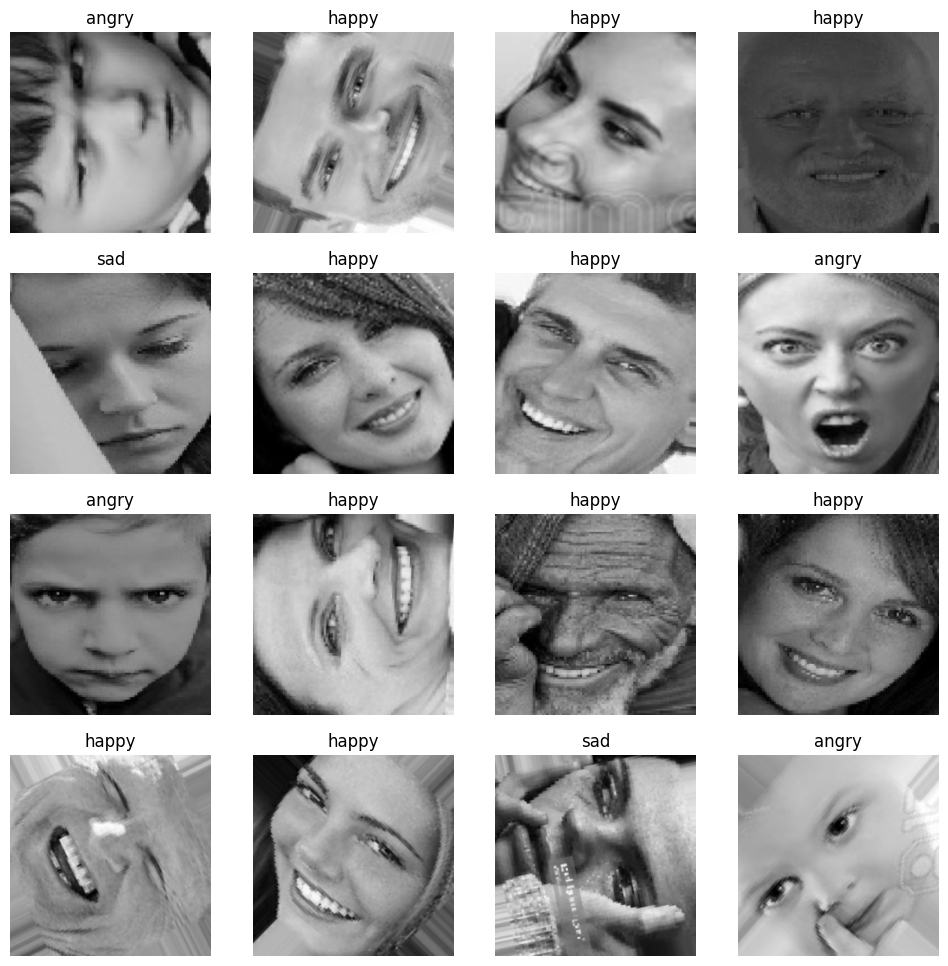

In [22]:
plt.figure(figsize=(12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()])
    plt.axis("off")

<h1> Dataset preparation </h1>

In [23]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

In [24]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [25]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling(1/255.)
])

In [26]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 1.35, 0.55]]
loss = CategoricalCrossentropy()
loss(y_true, y_pred).numpy()

0.6711387

<h1> Model </h1>

In [27]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

<h1> Training </h1>

<h3> define loss function </h3>

In [28]:
loss_function = CategoricalCrossentropy()
# loss_function = SparseCategoricalCrossentropy()

<h3> define metrics </h3>

In [29]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

<h3> compile the model </h3>

In [30]:
lenet_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

<h3> Training process </h3>

In [ ]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
)

Epoch 1/20
213/213 [==============================] - 30s 102ms/step - loss: 0.9603 - accuracy: 0.5735 - top_k_accuracy: 0.8287 - val_loss: 1.0851 - val_accuracy: 0.4118 - val_top_k_accuracy: 0.7823
Epoch 2/20
213/213 [==============================] - 22s 100ms/step - loss: 0.6132 - accuracy: 0.7467 - top_k_accuracy: 0.9154 - val_loss: 0.9597 - val_accuracy: 0.5610 - val_top_k_accuracy: 0.7968
Epoch 3/20
213/213 [==============================] - 22s 102ms/step - loss: 0.3652 - accuracy: 0.8665 - top_k_accuracy: 0.9685 - val_loss: 1.0336 - val_accuracy: 0.6642 - val_top_k_accuracy: 0.8657
Epoch 4/20
213/213 [==============================] - 22s 101ms/step - loss: 0.2354 - accuracy: 0.9219 - top_k_accuracy: 0.9851 - val_loss: 0.8848 - val_accuracy: 0.7191 - val_top_k_accuracy: 0.8977
Epoch 5/20
213/213 [==============================] - 21s 98ms/step - loss: 0.1679 - accuracy: 0.9459 - top_k_accuracy: 0.9910 - val_loss: 1.0894 - val_accuracy: 0.6971 - val_top_k_accuracy: 0.8942
Epoch 

In [ ]:
type(history)

keras.src.callbacks.History

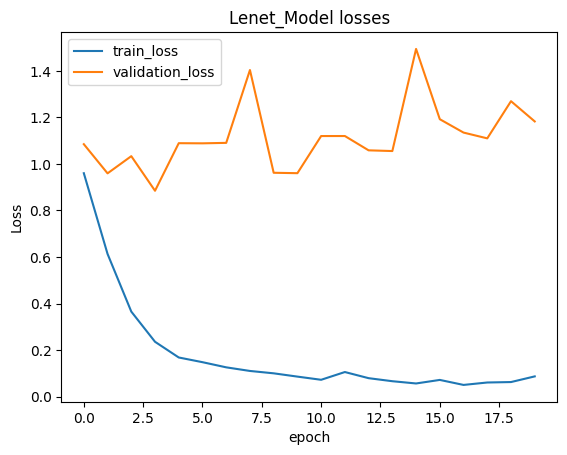

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Lenet_Model losses")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "validation_loss"])
plt.show()

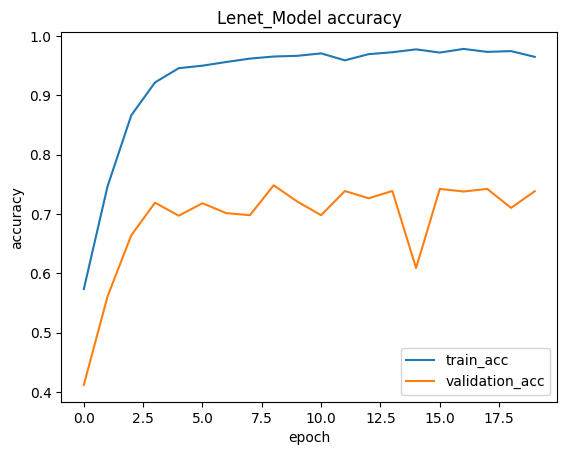

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Lenet_Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_acc", "validation_acc"])
plt.show()

<h1> Evaluation </h1>

In [ ]:
lenet_model.evaluate(validation_dataset)

2278/2278 [==============================] - 11s 5ms/step - loss: 1.1830 - accuracy: 0.7384 - top_k_accuracy: 0.9078


[1.1829917430877686, 0.738366961479187, 0.9078138470649719]

<h1> Testing </h1>

In [ ]:
test_random_sample = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
im = tf.constant(test_random_sample, dtype=tf.float32)
print(im.shape)

(90, 90, 3)


In [ ]:
# to conform with model input shape
im = tf.expand_dims(im, axis=0)
im.shape

TensorShape([1, 90, 90, 3])

In [ ]:
lenet_model(im)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[2.0673725e-10, 9.9999571e-01, 4.3455725e-06]], dtype=float32)>

In [ ]:
CONFIGURATION["CLASS_NAMES"][np.squeeze(tf.argmax(lenet_model(im), axis=-1).numpy())]

'happy'

<h1> Confusion Matrix </h1>

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [ ]:
labels[1]

array([[0., 0., 1.]], dtype=float32)

In [ ]:
predicted[1]

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.3661706e-04, 8.2754884e-03, 9.9158794e-01]], dtype=float32)>

In [ ]:
# not picking the last batch, many times the len of last batch is less than the fixed size.
# if our dataset has 98 elements, we will have 3 batches of 32 images and 2 images in the last section
# so we do not pick the last batch to avoid an error in the code
# my batch size here is 1, so there is no problem in this code

print(np.argmax(labels[:-1], axis=-1))

[[1]
 [2]
 [1]
 ...
 [2]
 [2]
 [2]]


In [ ]:
# let's pick the first two batches
print(np.argmax(labels[:], axis=-1).flatten())

[1 2 1 ... 2 2 0]


In [ ]:
len(np.argmax(labels[:], axis=-1).flatten())

2278

In [ ]:
print(np.argmax(predicted[:], axis=-1).flatten())

[1 2 1 ... 2 1 1]


In [ ]:
len(np.argmax(predicted[:], axis=-1).flatten())

2278

In [ ]:
preds = np.argmax(predicted[:], axis=-1).flatten()
true_classes = np.argmax(labels[:], axis=-1).flatten()

[[307 116  92]
 [ 35 843 128]
 [ 69 156 532]]


Text(0.5, 58.7222222222222, 'Predicted')

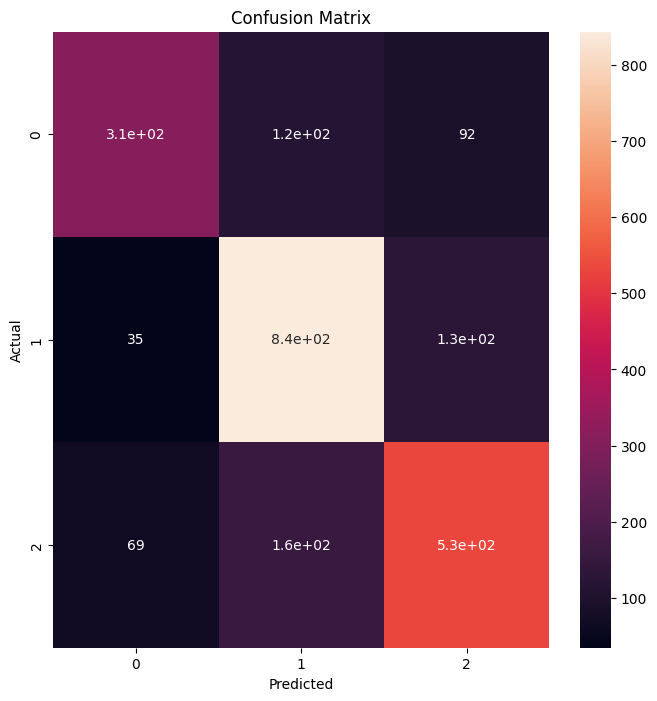

In [ ]:
cm = confusion_matrix(y_true=true_classes, y_pred=preds)

print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

<h1> Data Augmentation </h1>

In [31]:
# make data augmentation through keras layers
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1)
])

In [32]:
# augmentation function

def augment_func(image, label):
  return augment_layers(resize_rescale_layers(image), training=True), label

<h3> integrating data augmentation only in training data </h3>

In [33]:
training_dataset = (
    train_dataset
    .map(augment_func, num_parallel_calls = tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE)
)

<h3> Train the model with data augmentation </h3>

In [34]:
lenet_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

Epoch 1/20
213/213 [==============================] - 68s 286ms/step - loss: 1.1275 - accuracy: 0.5713 - top_k_accuracy: 0.8293 - val_loss: 83.7220 - val_accuracy: 0.3323 - val_top_k_accuracy: 0.9877
Epoch 2/20
213/213 [==============================] - 62s 288ms/step - loss: 0.8705 - accuracy: 0.6021 - top_k_accuracy: 0.8542 - val_loss: 130.6326 - val_accuracy: 0.2678 - val_top_k_accuracy: 0.6532
Epoch 3/20
213/213 [==============================] - 60s 281ms/step - loss: 0.7611 - accuracy: 0.6614 - top_k_accuracy: 0.8906 - val_loss: 203.8851 - val_accuracy: 0.3306 - val_top_k_accuracy: 0.9881
Epoch 4/20
213/213 [==============================] - 59s 276ms/step - loss: 0.7981 - accuracy: 0.6625 - top_k_accuracy: 0.8837 - val_loss: 84.7018 - val_accuracy: 0.3314 - val_top_k_accuracy: 0.9302
Epoch 5/20
213/213 [==============================] - 61s 284ms/step - loss: 0.6386 - accuracy: 0.7244 - top_k_accuracy: 0.9210 - val_loss: 27.5110 - val_accuracy: 0.4649 - val_top_k_accuracy: 0.778

<h3> Visualizing the result </h3>

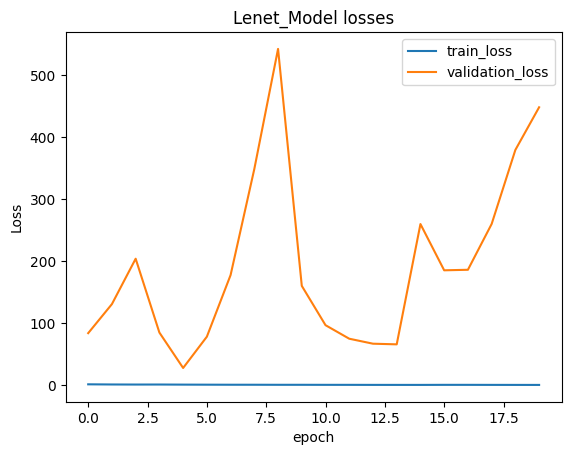

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Lenet_Model losses")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "validation_loss"])
plt.show()

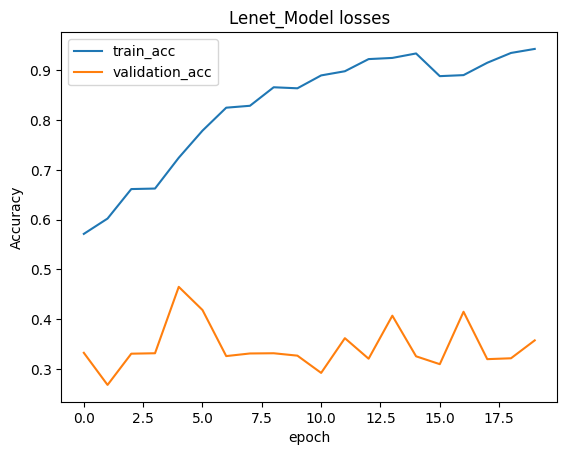

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Lenet_Model losses")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(["train_acc", "validation_acc"])
plt.show()

<h3> Why validation loss is so low? </h3>

<h4> After all augmentation is expected to enhance model's performance </h4>

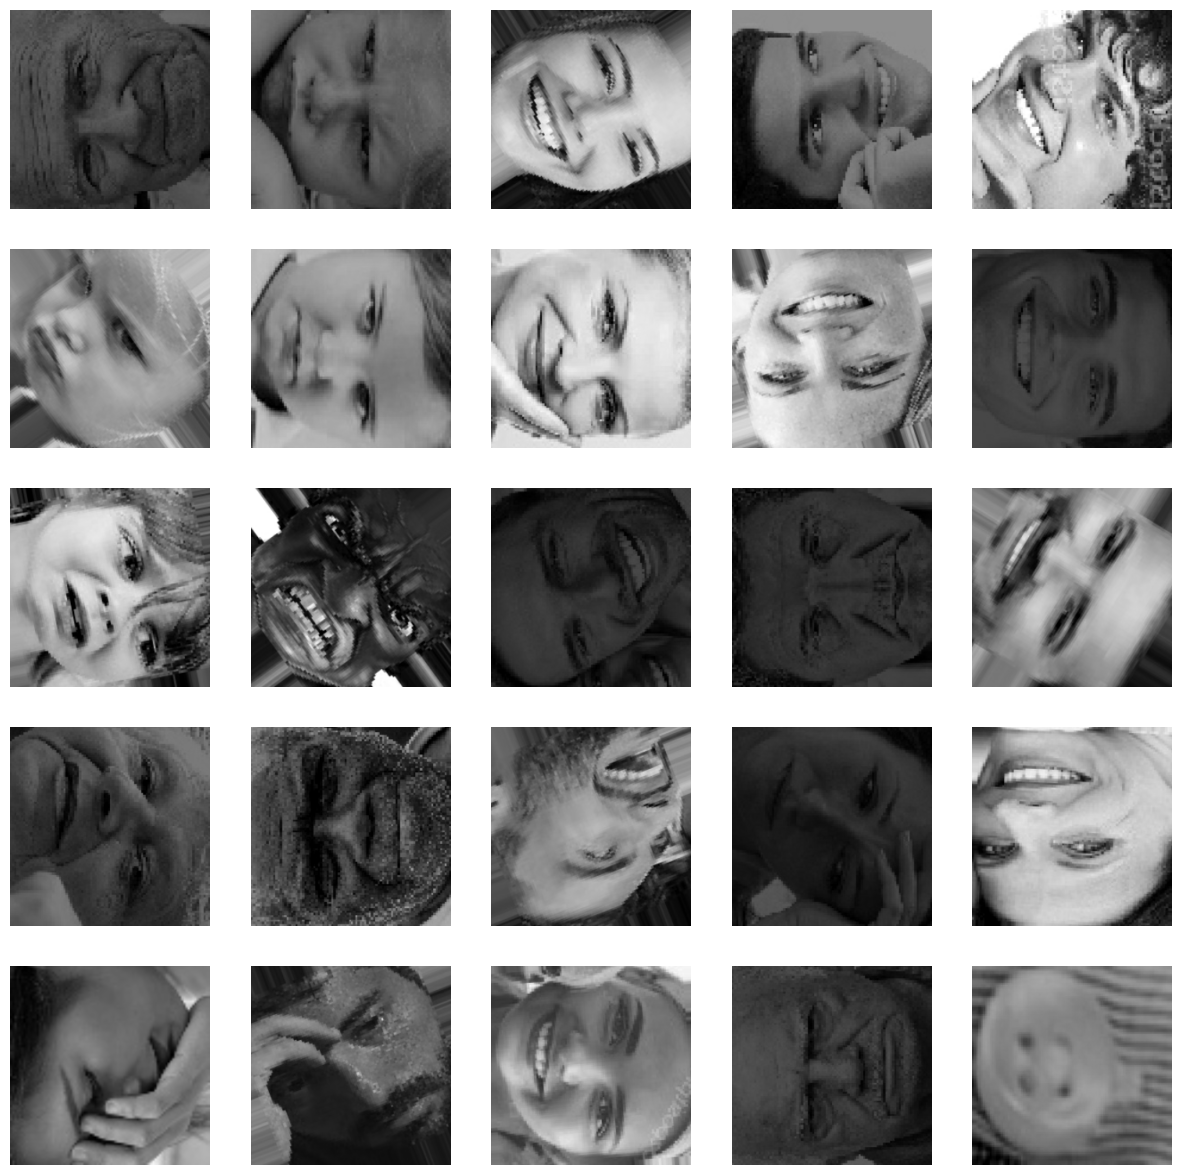

In [35]:
# to understand the reason behind this drop, let's visualiza the result of our augmentation

plt.figure(figsize=(15, 15))

for image, label in training_dataset.take(1):
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(image[i])
    plt.axis("off")

<h4> As you can see, the data augmentation alter some pictures to nonsensical images of faces, the noise and effect added to them make them unrealistic and out of natural shape, so the model will learn patterns not existing in our validation set </h4>

<h4> limiting our rotation between -0.025 rad to 0.025 rad which is -9 to 9 degrees </h4>


In [37]:
augmentation_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1)
])

In [38]:
def augment_func(image, label):
  return augmentation_layers(resize_rescale_layers(image), training=True), label

<h2> Cutmix augmentation </h2>

In [45]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [46]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [47]:
train_dataset_1 = train_dataset.map(augment_func, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_func, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [48]:
training_dataset = (
   mixed_dataset
   .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
   .prefetch(tf.data.AUTOTUNE)
)

In [50]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

Epoch 1/20
 51/213 [======>.......................] - ETA: 9:12 - loss: 1.2706 - accuracy: 0.4516 - top_k_accuracy: 0.7494

KeyboardInterrupt: 